In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [2]:
'''A transformation pipeline converts images to tensors and normalizes them to ensure numerical compatibility and improve the training stability of neural networks.
'''
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [3]:
'''
Create data loaders for training and validation datasets with batch size 64 and shuffling enabled
Shuffling the dataset during training helps prevent the model from learning the order or sequence of the data.
'''
trainset = datasets.MNIST('dataset/train', download=True, train=True, transform=transform)
valset = datasets.MNIST('dataset/test', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


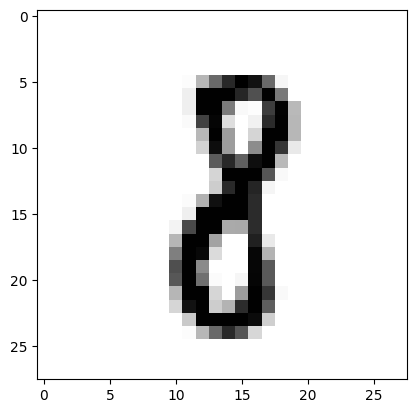

In [5]:
plt.imshow(images[45].numpy().squeeze(), cmap='gray_r');

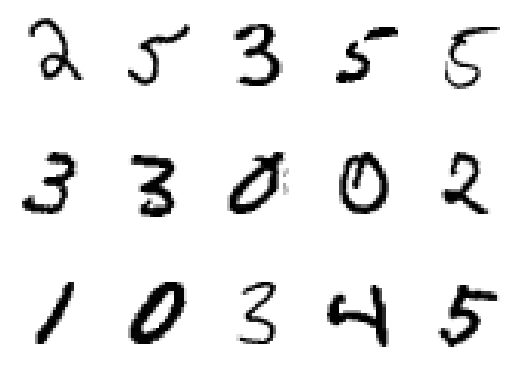

In [6]:
figure = plt.figure()
num_of_images = 15
for index in range(1, num_of_images + 1):
    plt.subplot(3, 5, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [7]:
''' 
Define a feedforward neural network model with two hidden layers and the ReLU activation function for a classification task, where input data with a size of 784 is transformed into class probabilities using LogSoftmax (The final layer.)
'''

input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [8]:
# Define the loss function as Negative Log Likelihood Loss (NLLLoss)

criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [9]:
images.shape

torch.Size([64, 784])

In [10]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0008, -0.0008, -0.0008,  ..., -0.0008, -0.0008, -0.0008],
        [-0.0022, -0.0022, -0.0022,  ..., -0.0022, -0.0022, -0.0022],
        [ 0.0005,  0.0005,  0.0005,  ...,  0.0005,  0.0005,  0.0005],
        ...,
        [-0.0022, -0.0022, -0.0022,  ..., -0.0022, -0.0022, -0.0022],
        [ 0.0028,  0.0028,  0.0028,  ...,  0.0028,  0.0028,  0.0028],
        [ 0.0016,  0.0016,  0.0016,  ...,  0.0016,  0.0016,  0.0016]])


2023-09-25 16:30:26.390 Python[6391:181556] apply_selection_policy_once: avoid use of removable GPUs (via org.python.python:GPUSelectionPolicy->avoidRemovable)


In [ ]:
training_loss = []
validation_accuracy = []

In [ ]:
'''
This line initializes a Stochastic Gradient Descent (SGD) optimizer with a learning rate of 0.003 and momentum of 0.9 to update the model's parameters during training. The learning rate controls the step size in the optimization landscape, while momentum accelerates convergence by considering the previous gradient step, aiding in overcoming local minima.
'''
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15

'''
In this part of the code, a neural network model is trained for a specified number of epochs on the MNIST dataset, utilizing a DataLoader (trainloader). For each epoch, the model iterates over batches of images and labels, flattening the images for input. The optimizer’s gradients are zeroed to prevent accumulation, followed by a forward pass through the model to compute predictions. The loss between the model’s output and true labels is calculated and backpropagated to update the model’s parameters. The training loss for each epoch is printed, and upon completion, the total training time is displayed.
'''
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
        epoch_loss = running_loss / len(trainloader)
        training_loss.append(epoch_loss)
print("\nTraining Time (in minutes) =",(time()-time0)/60)

In [ ]:
# Plot the training loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), training_loss, marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

In [ ]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()
     

In [ ]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

In [11]:
'''
This code snippet calculates the accuracy of the trained model on the validation dataset. It initializes two counters, correct_count and all_count, and iterates over batches of images and labels from valloader. For each image, it reshapes the image, performs a forward pass through the model to obtain log probabilities (logps), and converts these to probabilities (ps). The model's predicted label is determined as the index of the maximum probability. If the predicted label matches the true label, correct_count is incremented. After evaluating all images, the total number of images tested and the model's accuracy, calculated as the ratio of correctly predicted images to the total number of images, are printed.
'''
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1
    

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))


Number Of Images Tested = 10000

Model Accuracy = 0.9758


## Code for question (c)

2023-09-25 16:33:44.609 Python[6489:186430] apply_selection_policy_once: avoid use of removable GPUs (via org.python.python:GPUSelectionPolicy->avoidRemovable)


Epoch 0 - Training loss: 0.593237796000072 - Validation loss: 0.30188314218050355
Epoch 1 - Training loss: 0.2682839208510893 - Validation loss: 0.22578119144887682
Epoch 2 - Training loss: 0.20141686527316632 - Validation loss: 0.18199618687485433
Epoch 3 - Training loss: 0.15931141874723154 - Validation loss: 0.14313616492091472
Epoch 4 - Training loss: 0.12965013779628315 - Validation loss: 0.1326391415041723
Epoch 5 - Training loss: 0.1093552576443518 - Validation loss: 0.1131610331380633
Epoch 6 - Training loss: 0.09448144358517264 - Validation loss: 0.09899419383590768
Epoch 7 - Training loss: 0.0819925853236914 - Validation loss: 0.09267775292039677
Epoch 8 - Training loss: 0.07202244047343588 - Validation loss: 0.08647603151287622
Epoch 9 - Training loss: 0.06412591774469373 - Validation loss: 0.09429315170925703
Epoch 10 - Training loss: 0.05791043893628712 - Validation loss: 0.08515049687106234
Epoch 11 - Training loss: 0.0515922356986685 - Validation loss: 0.0772441436868801

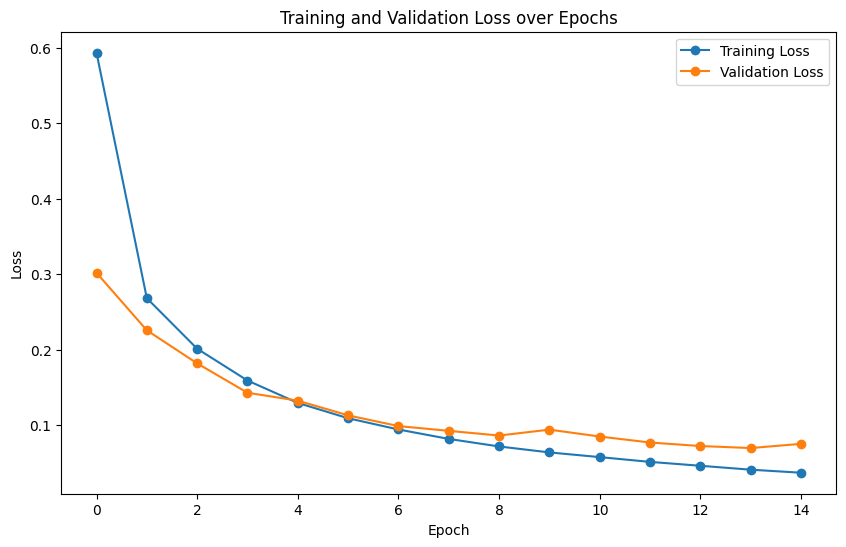

In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
# Initialize lists to store the training and validation losses
training_losses = []
validation_losses = []

# Set the number of epochs for training
epochs = 15

# Start the training loop
for e in range(epochs):
    running_loss = 0
    # Training Loop
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass: compute predictions by passing inputs through the model
        output = model(images)
        
        # Compute the loss between the model output and the true labels
        loss = criterion(output, labels)
        
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # Perform a single optimization step (parameter update)
        optimizer.step()
        
        # Update the running loss
        running_loss += loss.item()
        
    # Calculate the training loss for the current epoch
    training_loss = running_loss / len(trainloader)
    training_losses.append(training_loss)
    
    # Validation Loop
    validation_loss = 0
    with torch.no_grad():
        for images, labels in valloader:
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)
            
            # Forward pass: compute predictions by passing inputs through the model
            output = model(images)
            
            # Compute the loss between the model output and the true labels
            loss = criterion(output, labels)
            
            # Update the running validation loss
            validation_loss += loss.item()
    
    # Calculate the validation loss for the current epoch
    validation_loss = validation_loss / len(valloader)
    validation_losses.append(validation_loss)
    
    # Print the training and validation losses for the current epoch
    print(f"Epoch {e} - Training loss: {training_loss} - Validation loss: {validation_loss}")

# Plot the training and validation losses over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), training_losses, marker='o', label='Training Loss')
plt.plot(range(epochs), validation_losses, marker='o', label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Code for question (d)

2023-09-25 16:44:03.897 Python[6557:189607] apply_selection_policy_once: avoid use of removable GPUs (via org.python.python:GPUSelectionPolicy->avoidRemovable)


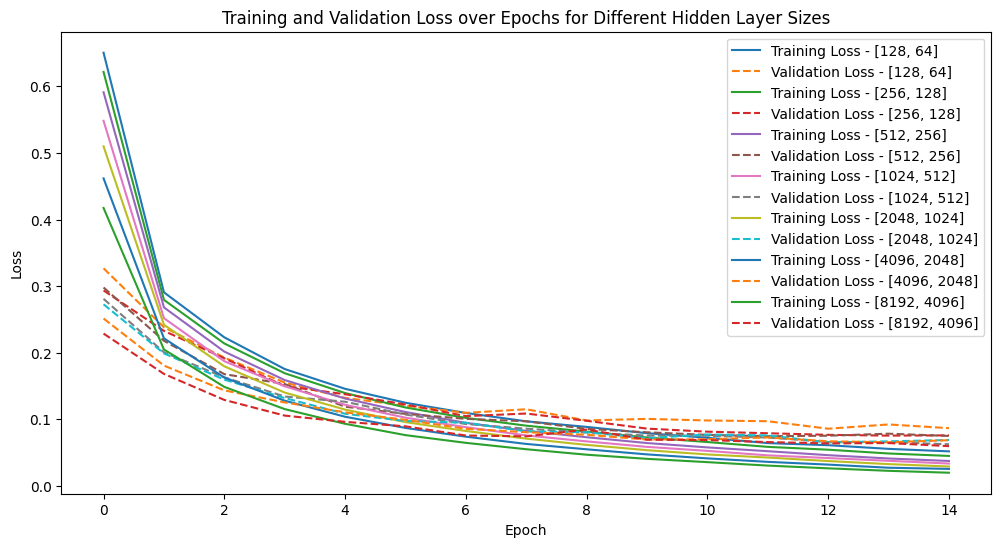

Final Accuracy for [128, 64] hidden neurons: 0.9731
Final Accuracy for [256, 128] hidden neurons: 0.9769
Final Accuracy for [512, 256] hidden neurons: 0.9755
Final Accuracy for [1024, 512] hidden neurons: 0.9797
Final Accuracy for [2048, 1024] hidden neurons: 0.9776
Final Accuracy for [4096, 2048] hidden neurons: 0.9782
Final Accuracy for [8192, 4096] hidden neurons: 0.981


In [10]:
# Define the number of input and output neurons
input_size = 784
output_size = 10

# Define different numbers of neurons for the hidden layers
hidden_layer_configurations = [
    [128, 64],
    [256, 128],
    [512, 256],
    [1024, 512],
    [2048, 1024],
    [4096, 2048],
    [8192, 4096],
    
]

# Initialize lists to store the training and validation losses for each configuration
all_training_losses = []
all_validation_losses = []

# Initialize a list to store the final accuracy for each configuration
final_accuracies = []

# Set the number of epochs for training
epochs = 15

# Iterate over different hidden layer configurations
for hidden_sizes in hidden_layer_configurations:
    # Define the model architecture using a Sequential container
    model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                          nn.ReLU(),
                          nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                          nn.ReLU(),
                          nn.Linear(hidden_sizes[1], output_size),
                          nn.LogSoftmax(dim=1))
    
    # Define the loss function and optimizer
    criterion = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
    
    # Initialize lists to store the training and validation losses for the current configuration
    training_losses = []
    validation_losses = []
    
    # Start the training loop
    for e in range(epochs):
        running_loss = 0
        for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)
        
        # Zero the parameter gradients
            optimizer.zero_grad()
        
        # Forward pass: compute predictions by passing inputs through the model
            output = model(images)
        
        # Compute the loss between the model output and the true labels
            loss = criterion(output, labels)
            
        # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
        
        # Perform a single optimization step (parameter update)
            optimizer.step()
        
        # Update the running loss
            running_loss += loss.item()
        
    # Calculate the training loss for the current epoch
        training_loss = running_loss / len(trainloader)
        training_losses.append(training_loss)
        
        # Validation Loop
        validation_loss = 0
        with torch.no_grad():
            for images, labels in valloader:
            # Flatten MNIST images into a 784 long vector
                images = images.view(images.shape[0], -1)
            
            # Forward pass: compute predictions by passing inputs through the model
                output = model(images)
            
            # Compute the loss between the model output and the true labels
                loss = criterion(output, labels)
            
            # Update the running validation loss
                validation_loss += loss.item()
    
    # Calculate the validation loss for the current epoch
        validation_loss = validation_loss / len(valloader)
        validation_losses.append(validation_loss)
    
    # Append the training and validation losses for the current configuration
    all_training_losses.append(training_losses)
    all_validation_losses.append(validation_losses)
    
    # Calculate the final accuracy on the validation set for the current configuration
    correct_count, all_count = 0, 0
    for images, labels in valloader:
        for i in range(len(labels)):
            img = images[i].view(1, 784)
            with torch.no_grad():
                logps = model(img)
            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            pred_label = probab.index(max(probab))
            true_label = labels.numpy()[i]
            if (true_label == pred_label):
                correct_count += 1
            all_count += 1
    final_accuracy = correct_count / all_count
    final_accuracies.append(final_accuracy)

# Plot the training and validation losses for each configuration
plt.figure(figsize=(12, 6))
for i, hidden_sizes in enumerate(hidden_layer_configurations):
    plt.plot(range(epochs), all_training_losses[i], label=f'Training Loss - {hidden_sizes}')
    plt.plot(range(epochs), all_validation_losses[i], label=f'Validation Loss - {hidden_sizes}', linestyle='dashed')
plt.title('Training and Validation Loss over Epochs for Different Hidden Layer Sizes')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Print the final accuracy for each configuration
for i, hidden_sizes in enumerate(hidden_layer_configurations):
    print(f"Final Accuracy for {hidden_sizes} hidden neurons: {final_accuracies[i]}")


In [11]:
# test